<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/practicals/P4.2_Graph_Classification_Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P4.2: Graph Classification (using Graph Neural Networks)
In this practical we will apply Graph Neural Networks (GNNs) to the task of classifying entire graphs. As in P4.1, we will use PyTorch and the PyTorch Geometric library[[1]](#pytorchgeomintro).

The main (learning) objectives of this practical are as follows:

*   Providing an overview of/discussion on the problem of classifying graphs.
*   How to use a GNN to classify entire graphs.
*   How to minibatch graphs (for PyTorch Geometric).



# Preparation
To start, we install the packages we need, set up some formatting for the notebook, and download the data we use in this practical.

In [ ]:
# PyTorch Geometric is not part of the standard Colab packages, we must install it ourselves
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 7.6MB/s 
     |████████████████████████████████| 1.5MB 5.2MB/s 
     |████████████████████████████████| 215kB 8.4MB/s 
     |████████████████████████████████| 235kB 34.6MB/s 
     |████████████████████████████████| 2.2MB 37.1MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


In [ ]:
# We want to limit the height of the output cells.
from IPython.display import HTML, display, Javascript

get_ipython().events.register('pre_run_cell', lambda: display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 450})')))

In [ ]:
# Download the dataset we use. 
# The dataset is part of torch_geometric, we do not need to construct it by hand.
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/mutagen', name='Mutagenicity', use_node_attr=True, use_edge_attr=False)

<IPython.core.display.Javascript object>

Extracting data/mutagen/Mutagenicity/Mutagenicity.zip
Processing...
Done!


In [ ]:
# Download some extra information for drawing examples of the dataset.
# The dataset considers elements: We download a map of indices to elements, and
# a map from elements to colors

from zipfile import ZipFile
import requests
import io
import pickle

def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/QqPycu7EWH2Frd9/download')

# load list that maps node indices to elements
element_map = pickle.load(io.BytesIO(data['element_map.pkl']))
# load dictionary that maps element to color
element_color = pickle.load(io.BytesIO(data['element_color.pkl']))

<IPython.core.display.Javascript object>

# Problem Formulation
The type of data we consider is graph data, where a graph is defined by its nodes and edges, $\mathcal{G} = (\mathcal{V},\mathcal{E})$. Note that, in contrast to P4.1, we do not look at one big graph. Rather, the dataset consists of many (smaller) graphs, and we seek to classify these graphs in their entirety. As such, a *graph* is analogous to an image in an image classification task, whereas in the previous tutorial a *node* was (somewhat) analogous to an image in said task.

We can define our data $X$ as a set of graphs, i.e., $X = \{\mathcal{G}_0, \mathcal{G}_1, \ldots, \mathcal{G}_n\}$. Labels $Y$ then map these graphs to a specific class $c \in C$, i.e., $Y = f: X \rightarrow C$

## Dataset: Database of molecules and their mutagenicity
The dataset we look at for this practical consists of molecules and their mutagenicity property[[2]](#mutagenicity). This property describes whether a molecule can induce genetic mutation or not, making it a binary attribute. 

The datapoints in the dataset are molecule-graphs $\mathcal{G} \in X$, and each such molecule-graph is assigned a label 0 (no mutagenicity) or 1 (mutagenicity). The nodes in the molecule-graph indicate (chemical) elements, whereas edges indicate connections between these elements.

We want to train a GNN to take these graphs as input and output a prediction. Note that there are no constraints on these graphs in terms of size or connections, our model must be able to process arbitrary graphs. This is where the use of GNNs shines, as this class of NN-models can process graphs of arbitrary shape.

Next, we will further examine our dataset and split it into a train and test set.


In [ ]:
'''
First, we will look at the dataset and some properties
'''
print(f'Number of examples: {len(dataset)}')
print('')
print("Let's print a few examples' shape:")
for i in range(4):
  print(dataset[i])

<IPython.core.display.Javascript object>

Number of examples: 4337

Let's print a few examples' shape:
Data(edge_attr=[32, 3], edge_index=[2, 32], x=[16, 14], y=[1])
Data(edge_attr=[154, 3], edge_index=[2, 154], x=[72, 14], y=[1])
Data(edge_attr=[26, 3], edge_index=[2, 26], x=[14, 14], y=[1])
Data(edge_attr=[76, 3], edge_index=[2, 76], x=[36, 14], y=[1])


The dataset consists of 4337 molecules. As we can see from printing a few examples, they vary in shape. As a reminder of what these tensors are, for an arbitrary graph $\mathcal{G}$:

$edge\_attr=[\mathcal{G}_\mathcal{E}, \mathcal{E}_a]$: Edge attributes, for each edge $\mathcal{E}$ in graph $\mathcal{G}$, we have $\mathcal{E}_a$ attributes. Note that we do not use these attributes in this notebook.

$edge\_index=[2, \mathcal{G}_\mathcal{E}]$: The tensor describing all edges in the graph. The first column describes the source node of each edge, whereas the second column describes the target node of each edge. E.g., $edge\_index=[[0, 1, 2], [3, 4, 5]]$ describes edges $(0, 3), (1, 4)$ and $(2, 5)$.

$x=[\mathcal{G}_\mathcal{V}, \mathcal{V}_a]$: The tensor describing all nodes and their attributes. For each node $\mathcal{V}$ in graph $\mathcal{G}$, we have $\mathcal{V}_a$ attributes.

$y=[1]$: The (binary) label for the graph.



The number of nodes and edges ($\mathcal{G}_\mathcal{V}$ and $\mathcal{G}_\mathcal{E}$) can differ for each graph, whereas the node and edge attributes ($\mathcal{V}_a$ and $\mathcal{E}_a$) are fixed for the entire dataset. As stated before, we do not use the edge attributes in this practical. The node attributes *are* used. Each node has a one-hot vector that indicates what element the node is. The following 14 elements are used in this dataset:
```
['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
```
For each node, the attribute is a vector of size 14, with 13 0s and a single 1. The index of this 1 indicates what element it is, according to the list printed above.

We aim to use these node attributes ($x$) along with their connections ($edge\_index$) to predict the mutagenicity of the molecule ($y$). To get an idea of what a single datapoint looks like, we define a function to draw one.

In [ ]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def draw_molecule(graph, title=''):
    plt.figure(figsize=(10, 5))
    nodes = {}  # create a node dict (idx:element) to create a nx graph
    for i in range(graph.x.shape[0]):
        element_idx = np.argmax(graph.x[i])
        nodes[i] = element_map[element_idx]
    edges = []  # create an edge list for the nx graph
    for i in range(graph.edge_index.shape[1]):
        s, t = graph.edge_index[:, [i]]
        s, t = int(s), int(t)
        edges.append((s, t))

    g = nx.Graph()  # create a graph
    g.add_nodes_from(nodes)
    g.add_edges_from(edges) 
    
    pos = nx.planar_layout(g)  # the graph has no 'position': generate a node-layout
    pos = nx.spring_layout(g, pos=pos)

    colors = [element_color[i] for _, i in nodes.items()]  # set the color for each node
    nx.draw(g, pos=pos, labels=nodes, node_color=colors, width=1)  # and draw the graph
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")  # color the edges
    
    display(HTML("""<style>#output-body {display: flex;align-items: center;justify-content: center;}</style>"""))  # center the image
    
    plt.title(title)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

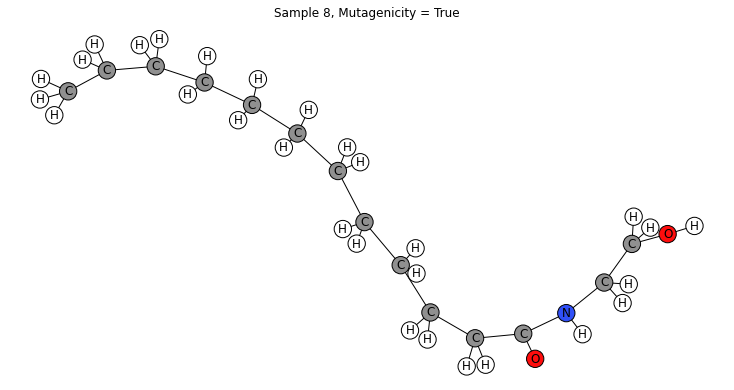

In [ ]:
idx = 8
draw_molecule(dataset[idx], f'Sample {idx}, Mutagenicity = {bool(dataset[idx].y)}')

Note that the location / layout of the nodes is somewhat arbitrary, and is generated by our drawing function. The graph information we have only considers the nodes' element, alongside what other nodes they are connected to. There are no 'coordinates' available.

Next, we will split our dataset into a train and test set and define a dataloader. The latter allows us to process graphs in minibatches.

In [ ]:
'''
We simply shuffle and split the dataset to create a train and test set.
'''
dataset.shuffle() # first, shuffle our dataset
train_idx = round(len(dataset) * 0.8) # 80:20 for the train:test split
dataset_train = dataset[:train_idx]
dataset_test = dataset[train_idx:]

<IPython.core.display.Javascript object>

In [ ]:
'''
To process the dataset in minibatches, we use a DataLoader object. All we must do
is supply the data and set the batch_size, PyTorch Geometric will take care of the rest.
Note that the batch_size indicates the number of graphs in a batch, not the number of nodes.
'''
from torch_geometric.data import DataLoader

batch_size = 256
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

<IPython.core.display.Javascript object>

In [ ]:
# To understand how graphs are batched, print one
for data in train_loader:
    print(data)
    break

<IPython.core.display.Javascript object>

Batch(batch=[8270], edge_attr=[16628, 3], edge_index=[2, 16628], ptr=[257], x=[8270, 14], y=[256])


Minibatching with graphs is slightly trickier than with individual datapoints, as each graph consists of a set of nodes which are processed by the GNN. In short, to efficiently process all nodes in a batch, PyTorch Geometric concatenates all node/edge data for all graphs in the batch to single tensors (which explains the singular and large $x$/$edge\_index$, etc). To be able to identify the individual graphs, a $batch$ tensor maps each node to the graph it belongs to. For more information, we refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches).

# Graph Classification
Now that we have discussed the problem and dataset, we move to the goal of this practical: Creating a model that can classify graphs.

In the cell below, you can define the body of a torch.nn.Module. We provide the num_features and num_classes, as these will be necessary when defining the model.

In [ ]:
num_features = int(dataset_train[0].x.shape[1])
num_classes = int(max([d.y for d in dataset_train])+1)

<IPython.core.display.Javascript object>

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_max_pool

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels) # we embed our initial node to hidden_channels
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes) # at the end, we max-pool our hidden embeddings, and predict a class

    def forward(self, x, edge_index, batch):
        # x is the node embeddings, (x_size, num_features)
        x = self.conv1(x, edge_index)  # one 'step' deep, (x_size, hidden_channels)
        x = x.relu()  # activation
        x = self.conv2(x, edge_index)  # (x_size, hidden_channels)
        x = x.relu()  # activation
        x = self.conv3(x, edge_index)  # (x_size, hidden_channels)
        x = x.relu()
        x = global_max_pool(x, batch)  # max-pool all nodes that belong to the same graph,
                                       # as indicated by the 'batch' tensor. The resulting
                                       # tensor has the same size as a node embedding, but
                                       # contains the maximum value for each dimension, 
                                       # according to all nodes in the graph. 
                                       # this is our graph embedding
                                       # (batch_size, hidden_channels)
                                      
        x = F.dropout(x, p=0.5, training=self.training)  # (batch_size, hidden_channels)
        x = self.lin(x)  # (batch_size, num_classes)
        
        return x

<IPython.core.display.Javascript object>

In [ ]:
'''
If possible, use cuda, as it will provide a reasonable speedup.
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Loaded device: {device}')

<IPython.core.display.Javascript object>

Loaded device: cuda


In [ ]:
'''
Training the GNN
'''
model = GraphSAGE(hidden_channels=32) # initialize our GNN
print(model)
model.to(device)  # and move to the GPU, if necessary

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # adam usually works well
loss_func = torch.nn.CrossEntropyLoss()  # we classify graphs, so use CCE as loss

def train():
    model.train()  # set the model to training mode (to apply dropout)
    for data in train_loader:  # loop through the training set in a batch-wise fashion
        data.to(device)  # move the batch to the device (GPU if applicable)
        optimizer.zero_grad()  # set gradients to 0
        out = model(data.x, data.edge_index, data.batch)  # propagate the data through the model
        loss = loss_func(out, data.y)  # compute the loss
        loss.backward()  # derive gradients
        optimizer.step()  # update all parameters based on the gradients


def test(loader):
    model.eval()  # set the model to evaluation mode (no dropout)
    
    correct = 0  # keep track of how many we have correct
    total = 0  # and how many we handle in total
    for data in loader:  # loop through the supplied dataset in a batch-wise fashion
        data.to(device)  # transfer batch to device
        out = model(data.x, data.edge_index, data.batch)  # propagate the data through the model
        pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
        correct += int((pred == data.y).sum())  # add the number of correct predictions
        total += len(data.y)  # and add the total number of elements
    return correct / total  # return the accuracy


train_accs = []
test_accs = []
epochs = 50
for epoch in range(1, epochs+50):  # train for 50 epochs
    loss = train()  # do one training step over the entire dataset
    train_acc = test(train_loader)  # compute the training accuracy
    test_acc = test(test_loader)  # compute the test accuracy
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)

<IPython.core.display.Javascript object>

GraphSAGE(
  (conv1): SAGEConv(14, 32)
  (conv2): SAGEConv(32, 32)
  (conv3): SAGEConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.6421, Test Acc: 0.6309
Epoch: 002, Train Acc: 0.6545, Test Acc: 0.6240
Epoch: 003, Train Acc: 0.6634, Test Acc: 0.6240
Epoch: 004, Train Acc: 0.6617, Test Acc: 0.6194
Epoch: 005, Train Acc: 0.6801, Test Acc: 0.6551
Epoch: 006, Train Acc: 0.7003, Test Acc: 0.6863
Epoch: 007, Train Acc: 0.7305, Test Acc: 0.7336
Epoch: 008, Train Acc: 0.7271, Test Acc: 0.7266
Epoch: 009, Train Acc: 0.7343, Test Acc: 0.7163
Epoch: 010, Train Acc: 0.7274, Test Acc: 0.7290
Epoch: 011, Train Acc: 0.7550, Test Acc: 0.7451
Epoch: 012, Train Acc: 0.7444, Test Acc: 0.7278
Epoch: 013, Train Acc: 0.7429, Test Acc: 0.7451
Epoch: 014, Train Acc: 0.7470, Test Acc: 0.7313
Epoch: 015, Train Acc: 0.7424, Test Acc: 0.7347
Epoch: 016, Train Acc: 0.7550, Test Acc: 0.7359
Epoch: 017, Train Acc: 0.7542, Test Acc: 0.7463
Epoch: 018, Train Acc: 0.755

In [ ]:
'''
To get an overview of the accuracy over the training period, we define a simple function
to plot the saved accuracies.
'''
def plot_train(train_accs, test_accs):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train_accs, color='blue', label='Train')
    ax.plot(test_accs, color='red', linestyle='--', label='Test')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

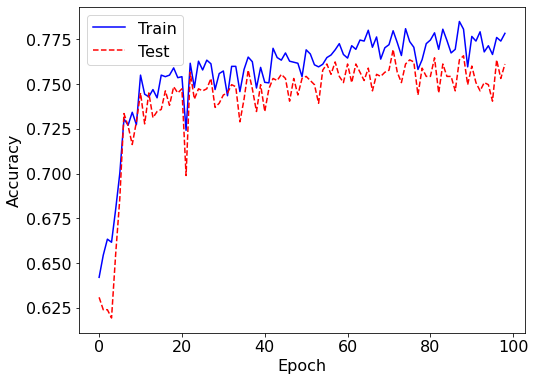

In [ ]:
plot_train(train_accs, test_accs)

# Evaluation and discussion

To conclude, we evaluate the performance of our model, and use it to make predictions. We define a simple function for testing and drawing a single molecule (from the test set).

In [ ]:
print(f'Final test accuracy: {test_accs[-1]}')

<IPython.core.display.Javascript object>

Final test accuracy: 0.7612456747404844


In [ ]:
def test_sample(idx):
    mol = dataset_test[idx]  # take our sample
    mol.to(device)  # put it on device
    pred = model(mol.x,  # propagate nodes
                 mol.edge_index,   #  edges
                 torch.zeros(mol.x.shape[0], dtype=torch.long).to(device))  # 'batch' object of 0s (the one graph in the batch)

    pred = pred.to('cpu')  # put data back on cpu
    mol = mol.to('cpu')
    pred = int(pred.argmax(dim=1))  # gather predictions
    true = int(mol.y)  
    outcome = ['No mutagenicity', 'Mutagenicity']
    outcome_text = 'Predicted = "{}", Ground-truth = "{}"'.format(outcome[pred], outcome[true])  # create outcome text
    draw_molecule(mol, title=f'Sample {idx}\n' + outcome_text)  # draw the prediction

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

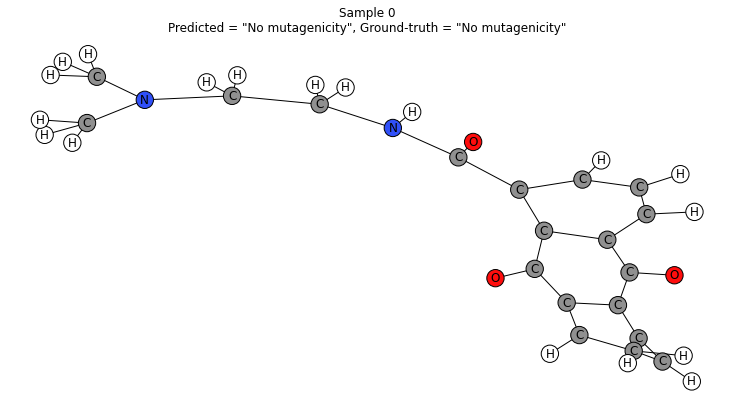

In [ ]:
test_sample(0)

## Discussion
This concludes the practical on graph classification. We have focused on how to use GNNs to classify entire graphs, where the graphs can be of arbitrary size.

We credit the Graph Classification tutorial provided by PyTorch Geometric[[3]](#pytorchgeom) as a foundation for this practical.

# References
<a name="pytorchgeomintro"></a>
[1] https://pytorch-geometric.readthedocs.io/en/latest/index.html 

<a name="mutagenicity"></a>
[2] Kazius, J., McGuire, R., & Bursi, R. (2005). Derivation and validation of toxicophores for mutagenicity prediction. Journal of medicinal chemistry, 48(1), 312-320.

<a name="pytorchgeom"></a>
[3] https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html